In [27]:
# This computes the optimal gamma and Probability of min error with a common covariance estimate

import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.integrate import nquad


def empirical_error(gamma, likelihood_ratios, labels):
    predictions = likelihood_ratios > gamma
    return np.mean(predictions != labels)

# Calculate likelihood ratios with the common covariance matrix
def likelihood_common_cov(samples, mean0, mean1, common_cov):
    GaussPDF0 = multivariate_normal.pdf(samples, mean=mean0, cov=common_cov)
    GaussPDF1 = multivariate_normal.pdf(samples, mean=mean1, cov=common_cov)
    return GaussPDF1 / GaussPDF0

In [28]:
Data = np.load('Data.npy') # The 10000 samples from Part A
truelabel = np.load('truelabel.npy') # labels from partA
mean0 = np.array([-1, -1, -1, -1])
mean1 = np.array([1, 1, 1, 1])

samples0 = Data[truelabel == 0]
samples1 = Data[truelabel == 1]

cov0 = np.cov(samples0, rowvar=False)
cov1 = np.cov(samples1, rowvar=False)


prior0 = len(samples0) / len(Data)
prior1 = len(samples1) / len(Data)

# calculating the common covariance matrix using estimator
common_cov = prior0 * cov0 + prior1 * cov1

In [29]:
likelihood_ratios = likelihood_common_cov(Data, mean0, mean1, common_cov)

# Optimum gamma
common_cov = minimize_scalar(empirical_error, bounds=(0, 1), args=(likelihood_ratios, truelabel), method='bounded')
optimal_gamma_common_cov = common_cov.x
min_error_common_cov = common_cov.fun

fpr, tpr, _ = roc_curve(truelabel, likelihood_ratios)
roc_auc = auc(fpr, tpr)

print(common_cov)

 message: Solution found.
 success: True
  status: 0
     fun: 0.0706
       x: 0.9980820359162436
     nit: 24
    nfev: 24


In [30]:
def errorFn(x1, x2, x3, x4):
    x = [x1, x2, x3, x4]
    return min(multivariate_normal.pdf(x, mean=mean0, cov=common_cov.x)*prior0, multivariate_normal.pdf(x, mean=mean1, cov=common_cov.x)*prior1)

opts = {'epsabs':1.e-2}
error, _ = nquad(errorFn,ranges=[[-5,5],[-5,5],[-5,5],[-5,5]],opts=opts)
print("Error:", error)

Error: 0.021488283011356264


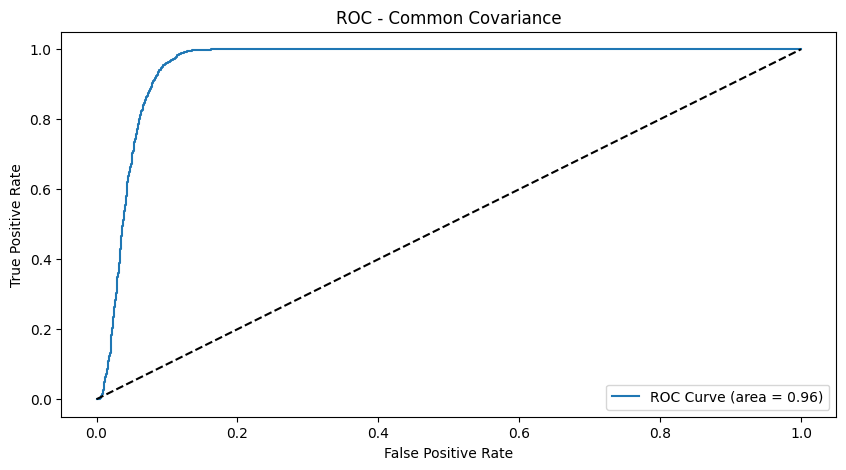

Optimal Gamma: 0.9981
Minimum Empirical Error: 0.0706


In [31]:
# Plotting ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Common Covariance')
plt.legend(loc="lower right")
plt.show()

print(f"Optimal Gamma: {optimal_gamma_common_cov:.4f}")
print(f"Minimum Empirical Error: {min_error_common_cov:.4f}")

In [32]:
#Plot Data Distribution
UpdatedData = np.empty((11, 11))

for i in range(11): 
        if (truelabel[i] == 0):
                UpdatedData[i, :] = multivariate_normal.pdf(Data, mean=mean0, cov=common_cov)
        elif (truelabel[i] == 1):
                UpdatedData[i, :] = multivariate_normal.pdf(Data, mean=mean1, cov=common_cov)

fig = plt.figure()
ax = plt.axes(projection = "3d")
Class0 = ax.scatter(UpdatedData[(truelabel==0),3],UpdatedData[(truelabel==0),1],UpdatedData[(truelabel==0),2],'+',color ='blue', label="0")
Class1 = ax.scatter(UpdatedData[(truelabel==1),3],UpdatedData[truelabel==1,1],UpdatedData[truelabel==1,2],'.',color = 'red', label="1")
plt.xlabel('X3')
plt.ylabel('X1')
ax.set_zlabel('X2')
ax.legend()
plt.title('Data Distribution')
plt.show()

TypeError: float() argument must be a string or a real number, not 'OptimizeResult'